In [2]:
from math import exp, sqrt
import itertools

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

## Konstante i osnovne funkcije

In [3]:
kb = 8.6173303 * 10**(-5)
pi = np.pi

hbar_w_op = 0.2
hbar_w_ac = 0.03
G_op2 = 0.25
G_ac2 = 0.05
eta = 7.85 * 10**(-3)
t = 2.52
Ef = 0.5
KF = Ef / 3 * 2 / t

In [4]:
def fermi_dirac(E, Ef, T): 
    if T > 0:
       if E > Ef:
           return exp((-E + Ef) / (kb * T)) / (exp((-E + Ef) / (kb * T)) + 1)
       else:
           return 1 / (exp((E - Ef) / (kb * T)) + 1)
    else:
        if E < Ef: 
            return 0 
        else: 
            return 1

def bose_einstein(E,T): 
    assert T > 0
    #return 1 / (exp(E / (kb * T)) - 1)
    return exp(-E / (kb * T)) / (-exp(-E / (kb * T)) + 1)

def chemical_potential(T):
    return Ef - pi**2 / 6 / Ef * (kb * T)**2

def eps(Kx, Ky):
    return 3 * t / 2 * sqrt(Kx**2 + Ky**2)

## Optički fononi


In [31]:
def ss_sum_part(Kx, Ky, hbar_w, hbar_w_ph, T, u):
    def summand(s1, s2):
        return ((bose_einstein(hbar_w_ph, T) + fermi_dirac(s1 * s2 * eps(Kx, Ky), s1 * s2 * u, T)) / (hbar_w + s1 * eps(KF, 0) - s1 * eps(Kx, Ky) + s2 * hbar_w_ph + eta * 1j)) * (sqrt(Kx**2 + Ky**2) - Kx) / sqrt(Kx**2 + Ky**2) if (Kx and Ky) else 0
    sum = 0
    for s1, s2 in itertools.product([-1,1], [-1, 1]):
        sum = sum + summand(s1, s2)
    return sum

def ss_sum_real(Kx, Ky, hbar_w, hbar_w_ph, T, u):
    return ss_sum_part(Kx, Ky, hbar_w, hbar_w_ph, T, u).real

def ss_sum_imag(Kx, Ky, hbar_w, hbar_w_ph, T, u):
    return ss_sum_part(Kx, Ky, hbar_w, hbar_w_ph, T, u).imag

def mem_fn(ss_sum_fn, hbar_w, hbar_w_ph, u=Ef, T=50):    
    integral_k = integrate.nquad(ss_sum_fn, ([-KF*4, KF*4], [-KF*4, KF*4]), args=(hbar_w, hbar_w_ph, T, u))[0]
    return -G_op2 * integral_k / (2*pi)**2 * 2


**Memorijska funkcija**

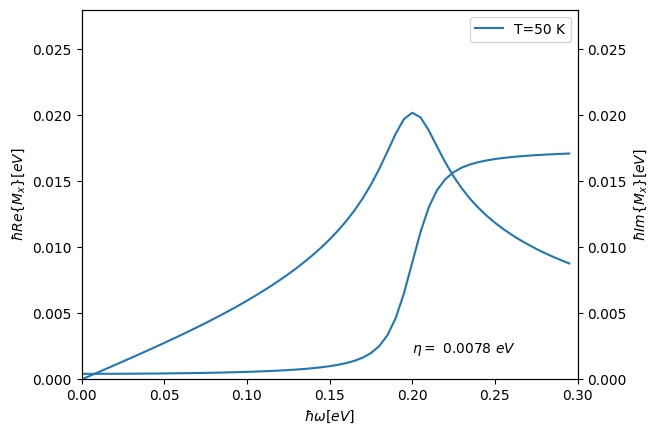

In [33]:
result_real = []
result_imag = []
ws = np.arange(0, 0.3, 0.005)
T=50
for w in ws:
    result_real.append(mem_fn(ss_sum_real, hbar_w=w, hbar_w_ph=hbar_w_op, u=chemical_potential(T)))
    result_imag.append(mem_fn(ss_sum_imag, hbar_w=w, hbar_w_ph=hbar_w_op, u=chemical_potential(T)))

fig, ax1 = plt.subplots()
ax1.plot(ws, result_real, label=f"T={T} K")
ax1.set_xlabel(r"$\hbar \omega [eV]$" )
ax1.set_ylabel(r"$\hbar Re\{M_x\} [eV]$" )
ax1.set_xlim([0.0, 0.3])
ax1.set_ylim([0.0, 0.028])

ax2 = ax1.twinx()
ax2.plot(ws, result_imag, label=f"T={T} K")
ax2.set_ylabel(r"$\hbar Im\{M_x\} [eV]$" )
ax2.set_xlim([0.0, 0.3])
ax2.set_ylim([0.0, 0.028])

plt.text(0.20, 0.002 , f"$\eta = $ {eta:.4f} $eV$" , fontsize =10)

plt.legend()
plt.show()

## Akustični fononi

In [39]:
def ss_sum_ac_part(Kx, Ky, hbar_w, hbar_w_ph, T, u):
    def summand(s1, s2):
        return (bose_einstein(hbar_w_ph * sqrt(Kx**2 + Ky**2), T) + fermi_dirac(s1 * s2 * eps(Kx, Ky), s1 * s2 * u, T)) / (hbar_w + s1 * eps(KF, 0) - s1 * eps(Kx, Ky) + s2 * hbar_w_ph * sqrt(Kx**2 + Ky**2) + eta * 1j)*(sqrt(Kx**2 + Ky**2) - Kx) * sqrt(Kx**2 + Ky**2) if (Kx and Ky) else 0
    sum = 0
    for s1, s2 in itertools.product([-1,1], [-1, 1]):
        sum = sum + summand(s1, s2)
    return sum

def ss_sum_ac_real(Kx, Ky, hbar_w, hbar_w_ph, T, u):
    return ss_sum_ac_part(Kx, Ky, hbar_w, hbar_w_ph, T, u).real

def ss_sum_ac_imag(Kx, Ky, hbar_w, hbar_w_ph, T, u):
    return ss_sum_ac_part(Kx, Ky, hbar_w, hbar_w_ph, T, u).imag

def mem_fn_ac(ss_sum_fn, hbar_w, hbar_w_ph, u=Ef, T=50):    
    integral_k = integrate.nquad(ss_sum_fn,  ([-KF*4, KF*4], [-KF*4, KF*4]), args=(hbar_w, hbar_w_ph, T, u))[0]
    return -G_ac2 * integral_k / (2*pi)**2 * 2

**Memorijska funkcija**

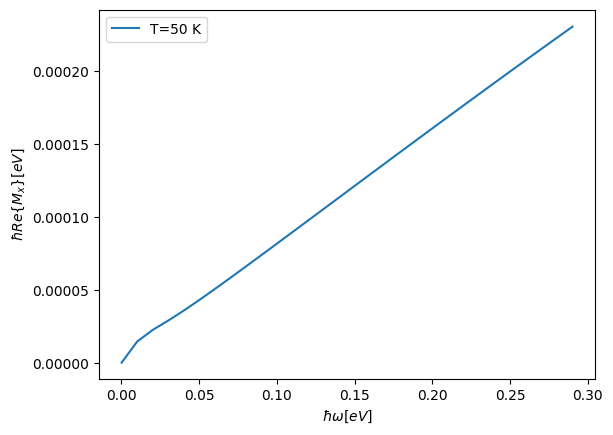

In [40]:
result_real = []
result_imag = []
ws = np.arange(0.0001, 0.3, 0.01)
T=50
for w in ws:
    result_real.append(mem_fn_ac(ss_sum_ac_real, hbar_w=w, hbar_w_ph=hbar_w_ac, u=chemical_potential(T)))
    #result_imag.append(mem_fn_ac(ss_sum_ac_imag, hbar_w=w, hbar_w_ph=hbar_w_ac, u=chemical_potential(T)))

fig, ax1 = plt.subplots()
ax1.plot(ws, result_real, label=f"T={T} K")
ax1.set_xlabel(r"$\hbar \omega [eV]$" )
ax1.set_ylabel(r"$\hbar Re\{M_x\} [eV]$" )
# ax1.set_xlim([0.0, 0.3])
# ax1.set_ylim([0.0, 0.001])

# ax2 = ax1.twinx()
# ax2.plot(ws, result_imag, label=f"T={T} K")
# ax2.set_ylabel(r"$\hbar Im\{M_x\} [eV]$" )
# ax2.set_xlim([0.0, 0.3])
# ax2.set_ylim([0.0, 0.001])

#plt.text(0.20, 0.002 , f"$\eta = $ {eta:.4f} $eV$" , fontsize =10)

plt.legend()
plt.show()